1. Loading and normalizing CIFAR10

Using torchvision, it’s extremely easy to load CIFAR10.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torch.__version__

'1.2.0'

Training on GPU

Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

Let’s first define our device as the first visible cuda device if we have CUDA available:

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

cuda:0


In [3]:
data_dir = 'Dogs/Images'

dataset = torchvision.datasets.ImageFolder(data_dir)

len(dataset)

20580

In [4]:
classes = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in dataset.classes:
    classes.append(rename(n))

classes


['Chihuahua',
 'Japanese spaniel',
 'Maltese dog',
 'Pekinese',
 'Shih Tzu',
 'Blenheim spaniel',
 'papillon',
 'toy terrier',
 'Rhodesian ridgeback',
 'Afghan hound',
 'basset',
 'beagle',
 'bloodhound',
 'bluetick',
 'black and tan coonhound',
 'Walker hound',
 'English foxhound',
 'redbone',
 'borzoi',
 'Irish wolfhound',
 'Italian greyhound',
 'whippet',
 'Ibizan hound',
 'Norwegian elkhound',
 'otterhound',
 'Saluki',
 'Scottish deerhound',
 'Weimaraner',
 'Staffordshire bullterrier',
 'American Staffordshire terrier',
 'Bedlington terrier',
 'Border terrier',
 'Kerry blue terrier',
 'Irish terrier',
 'Norfolk terrier',
 'Norwich terrier',
 'Yorkshire terrier',
 'wire haired fox terrier',
 'Lakeland terrier',
 'Sealyham terrier',
 'Airedale',
 'cairn',
 'Australian terrier',
 'Dandie Dinmont',
 'Boston bull',
 'miniature schnauzer',
 'giant schnauzer',
 'standard schnauzer',
 'Scotch terrier',
 'Tibetan terrier',
 'silky terrier',
 'soft coated wheaten terrier',
 'West Highland wh

In [5]:
random_seed = 45
torch.manual_seed(random_seed)

test_pct = 0.2
test_size = int(len(dataset)*test_pct)
train_size = len(dataset) - test_size

train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)

(16464, 4116)

Appenzeller
<class 'PIL.Image.Image'>


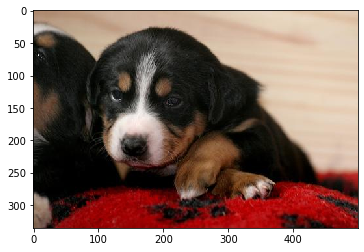

In [6]:
import matplotlib.pyplot as plt

img, label = train_ds[6]
print(classes[label])
plt.imshow(img)
print(type(img))


In [7]:
class DogBreedClassification(torch.utils.data.Dataset):

    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)
            return img, label

In [8]:
train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = DogBreedClassification(train_ds, train_transform)
test_dataset = DogBreedClassification(test_ds, test_transform)

Lets quickly take a look into our training dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8


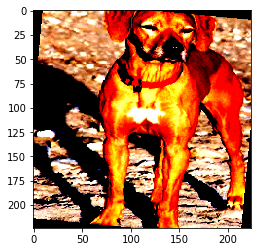

In [9]:
img, label = train_dataset[22]
print(label)
plt.imshow(img.permute(1,2,0))


creating Training , validation data and test data loader

In [10]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [33]:
batch_size =64

# Create DataLoaders
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = torch.utils.data.DataLoader(test_dataset, 147, num_workers=2, pin_memory=True)

# moving train dataloader and val dataloader to gpu
trainloader = DeviceDataLoader(train_dl, device)
testloader = DeviceDataLoader(test_dl, device)


Let us show some of the training images, for fun.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


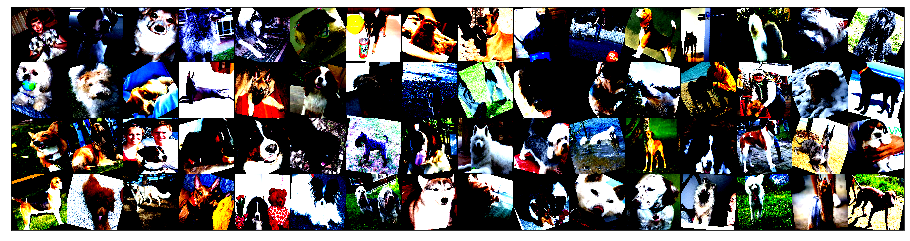

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

show_batch(train_dl)

2. Define a Convolutional Neural Network

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [21]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.conv4 = nn.Conv2d(32, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv_bn1 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 10 * 10, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 120)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.conv_bn1(x)
        x = x.view(-1, 64 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = to_device(Net(),device)

net


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=120, bias=True)
)

3. Define a Loss function and optimizer

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



4. Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [ ]:
import time

start_time = time.time()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = to_device(data,device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            print('Time taken: '+ str(time.time()-start_time))
            start_time = time.time()
            running_loss = 0.0

print('Finished Training')

Let’s quickly save our trained model:

In [ ]:
PATH = './dogs_net.pth'
torch.save(net.state_dict(), PATH)

5. Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


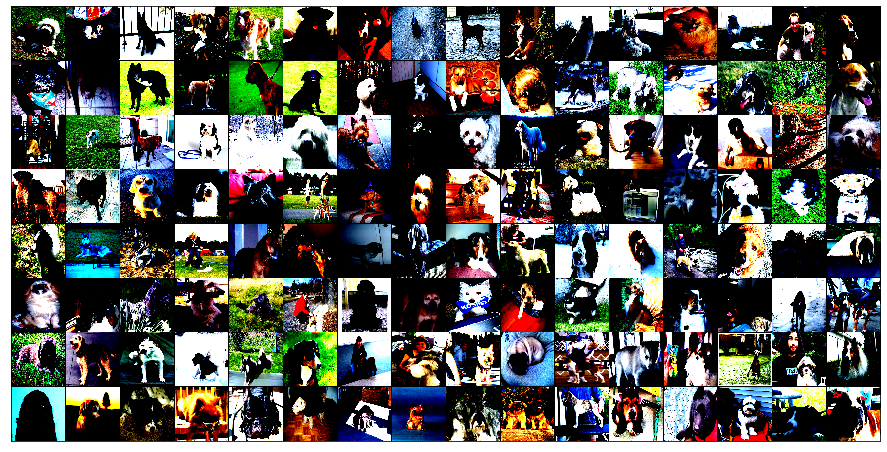

In [15]:
dataiter = iter(testloader.dl)
images, labels = to_device(dataiter.next(),device)

show_batch(test_dl)

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):


In [23]:
PATH = './dogs_net.pth'
net = Net().to(device)
net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:


In [24]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:


In [25]:
_, predicted = torch.max(outputs,1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:  Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfhound Irish wolfho

The results seem pretty good.

Let us look at how the network performs on the whole dataset.


In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 0 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:


In [34]:
class_correct = list(0. for i in range(120))
class_total = list(0. for i in range(120))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(147):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(120):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of Chihuahua :  0 %
Accuracy of Japanese spaniel :  0 %
Accuracy of Maltese dog :  0 %
Accuracy of Pekinese :  0 %
Accuracy of Shih Tzu :  0 %
Accuracy of Blenheim spaniel :  0 %
Accuracy of papillon :  0 %
Accuracy of toy terrier :  0 %
Accuracy of Rhodesian ridgeback :  0 %
Accuracy of Afghan hound :  0 %
Accuracy of basset :  0 %
Accuracy of beagle :  0 %
Accuracy of bloodhound :  0 %
Accuracy of bluetick :  0 %
Accuracy of black and tan coonhound :  0 %
Accuracy of Walker hound :  0 %
Accuracy of English foxhound :  0 %
Accuracy of redbone :  0 %
Accuracy of borzoi :  0 %
Accuracy of Irish wolfhound : 100 %
Accuracy of Italian greyhound :  0 %
Accuracy of whippet :  0 %
Accuracy of Ibizan hound :  0 %
Accuracy of Norwegian elkhound :  0 %
Accuracy of otterhound :  0 %
Accuracy of Saluki :  0 %
Accuracy of Scottish deerhound :  0 %
Accuracy of Weimaraner :  0 %
Accuracy of Staffordshire bullterrier :  0 %
Accuracy of American Staffordshire terrier :  0 %
Accuracy of Bedling